# MÔ HÌNH HÓA DỮ LIỆU
- **VỀ DỮ LIỆU:** Dữ liệu được thu thập thêm từ thông tin chi tiết của các địa điểm của một quốc gia. Có các cột là giá trị các thông tin chi tiết đó. Và có một cột target chính là kết quả mà ta sẽ suy ra từ bộ dữ liệu input. Dữ liệu có thể được cập nhật theo ngày tháng, do đó dữ liệu sẽ gần như vô hạn. Tuy nhiên, ta chỉ dùng một ngày cố định, thường sẽ dùng today().
- **VỀ MÔ HÌNH:** Ta sẽ chọn 2 mô hình:
  - Mô hình gom nhóm Random Forest.
  - Mô hình hồi quy tuyến tính Logitis Regression.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Các thư viện hỗ trợ thêm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Đọc file input dữ liệu:

- Ta có thể lấy dữ liệu gần nhất, dữ liệu today()
- Ta có thể lấy dữ liệu các ngày đã thu thập.

In [2]:
from os import walk
filenames = next(walk('./data/data'), (None, None, []))[2]  # [] if no file

# Nếu muốn train trên bộ dữ liệu là ngày hôm nay today()
# filename = filenames[-1]
# df = pd.read_csv(f'./data/data/{filename}')

# Nếu muốn test trên bộ dữ liệu là các ngày mà ta thu thập...
cnt = 0
for filename in filenames:    
    if cnt == 0:
        df = pd.read_csv(f'./data/data/{filename}')
    else:
        df = pd.concat([df, pd.read_csv(f'./data/data/{filename}')])
    cnt += 1
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,CO,target
0,Trời quang,11°C,52%,8.8 km/h,1017 mbar,61.3,185.3,2,52.2,10.4,1160.0,Không lành mạnh
1,Trời quang,12°C,44%,9.4 km/h,1016 mbar,139.2,245.5,4.5,44.6,8.8,1150.0,Không lành mạnh
2,Nhiều mây,-4°C,45%,5 km/h,1036 mbar,157,416.5,9,59,27.5,NaN,Rất không lành mạnh
3,Sương mù,12°C,87%,7.4 km/h,1016 mbar,123.9,222.3,23,54.8,NaN,NaN,Không lành mạnh
4,Trời quang,12°C,56%,7.1 km/h,1016 mbar,83.3*,NaN,NaN,NaN,NaN,NaN,Không lành mạnh


In [3]:
df['target'].value_counts()

Tốt                                      1732
Trung bình                                743
Không lành mạnh cho các nhóm nhạy cảm     250
Không lành mạnh                           238
Rất không lành mạnh                        34
Nguy hiểm                                  20
Name: target, dtype: int64

Quy các kiểu dữ liệu `string` về thành `int` để có thể tính mean

In [4]:
weather = ['Nhiều mây', 'Trời quang', 'Mưa', 'Mây rải rác', 'Sương mù', 'Ít mây', 'Tuyết', 'Mưa rào', 'Giông bão']
target = ['Tốt', 'Trung bình', 'Không lành mạnh', 'Không lành mạnh cho các nhóm nhạy cảm', 
          'Rất không lành mạnh', 'Nguy hiểm']
df = df.replace(weather, np.arange(len(weather)) + 1)
df = df.replace(target, np.arange(len(target)) + 1)
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,CO,target
0,2,11°C,52%,8.8 km/h,1017 mbar,61.3,185.3,2,52.2,10.4,1160.0,3
1,2,12°C,44%,9.4 km/h,1016 mbar,139.2,245.5,4.5,44.6,8.8,1150.0,3
2,1,-4°C,45%,5 km/h,1036 mbar,157,416.5,9,59,27.5,NaN,5
3,5,12°C,87%,7.4 km/h,1016 mbar,123.9,222.3,23,54.8,NaN,NaN,3
4,2,12°C,56%,7.1 km/h,1016 mbar,83.3*,NaN,NaN,NaN,NaN,NaN,3


Format lại các thông tin trong dữ liệu

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['Nhiệt độ'] = df['Nhiệt độ'].str.replace('°C', '')
    df['Độ ẩm'] = df['Độ ẩm'].str.replace('%', '')
    df['Gió'] = df['Gió'].str.replace(' km/h', '')
    df['Áp suất'] = df['Áp suất'].str.replace(' mbar', '')
    df[' PM2.5 '] = df[' PM2.5 '].str.replace('*', '')
    df[' PM10 '] = df[' PM10 '].str.replace('*', '')
    df[' O3 '] = df[' O3 '].str.replace('*', '')
    df[' NO2 '] = df[' NO2 '].str.replace('*', '')
    df[' SO2 '] = df[' SO2 '].str.replace('*', '')
    df[' CO '] = df[' CO '].str.replace('*', '')

In [6]:
df = df.astype(np.float64)
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,CO,target
0,2.0,11.0,52.0,8.8,1017.0,61.3,185.3,2.0,52.2,10.4,NaN,3.0
1,2.0,12.0,44.0,9.4,1016.0,139.2,245.5,4.5,44.6,8.8,NaN,3.0
2,1.0,-4.0,45.0,5.0,1036.0,157.0,416.5,9.0,59.0,27.5,NaN,5.0
3,5.0,12.0,87.0,7.4,1016.0,123.9,222.3,23.0,54.8,NaN,NaN,3.0
4,2.0,12.0,56.0,7.1,1016.0,83.3,NaN,NaN,NaN,NaN,NaN,3.0


Như đã thấy thì dữ liệu của mô hình có các giá trị NaN. Ta không thể drop các giá trị đó hoặc thay bằng 0, có nhiều cách để thay thế giá trị NaN, tuy nhiên ở đây chúng ta sẽ thay các giá trị NaN bằng mean.

In [7]:
X = df.iloc[:, :-1]
Y = df['target']

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(X)
X = imputer.transform(X)

Từ dữ liệu ta sẽ tạo ra tập train và tập test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

## MÔ HÌNH 1: **RANDOM FOREST**
- X sẽ là các cột dữ liệu thông tin về thời tiết và không khí.
- Y sẽ là các kết quả thực tế đo được.

In [9]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

Sau đó fix dữ liệu train với model

In [10]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

RandomForestClassifier()

Tập dự đoán 

In [11]:
y_pred = clf.predict(X_test)
y_pred

array([1., 1., 1., 2., 4., 4., 1., 1., 1., 2., 1., 1., 1., 3., 1., 1., 2.,
       1., 2., 1., 2., 1., 1., 1., 1., 2., 3., 1., 4., 2., 1., 2., 1., 3.,
       1., 3., 1., 1., 1., 1., 2., 2., 1., 1., 3., 1., 1., 1., 3., 2., 3.,
       1., 2., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 4., 1., 2., 3., 1.,
       1., 2., 1., 1., 1., 5., 1., 2., 3., 1., 1., 2., 1., 2., 2., 1., 1.,
       3., 1., 1., 4., 1., 2., 1., 1., 1., 2., 3., 1., 1., 2., 2., 1., 2.,
       2., 1., 1., 1., 1., 1., 2., 2., 2., 1., 2., 1., 2., 1., 1., 1., 1.,
       1., 1., 2., 1., 3., 1., 1., 1., 1., 4., 1., 2., 1., 2., 3., 1., 4.,
       1., 1., 1., 2., 1., 3., 1., 1., 2., 1., 1., 2., 2., 1., 3., 2., 1.,
       1., 3., 1., 1., 1., 3., 1., 3., 1., 4., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 3., 1., 4., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2.,
       1., 1., 1., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       4., 1., 1., 1., 2., 1., 1., 2., 1., 1., 6., 1., 2., 1., 1., 2., 2.,
       1., 1., 1., 1., 1.

### **ĐÁNH GIÁ MÔ HÌNH**

#### 1. **Confusion Matrix** (ma trận kiểm chứng tính đúng sai giữa true label và predicted label)

In [12]:
test = confusion_matrix(y_test, y_pred)
test

array([[556,   0,   0,   0,   0,   0],
       [  0, 205,   0,   0,   0,   0],
       [  0,   0,  76,   0,   0,   0],
       [  0,   2,   0,  54,   0,   0],
       [  0,   0,   3,   0,   3,   0],
       [  0,   0,   1,   0,   3,   3]], dtype=int64)

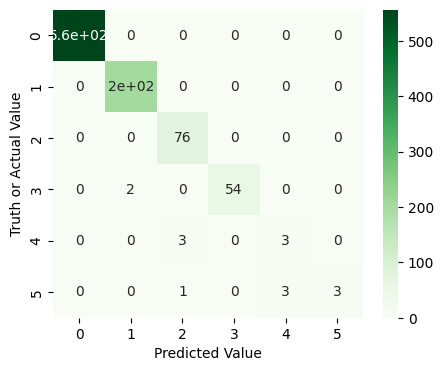

In [13]:
plt.figure(figsize = (5,4))
sns.heatmap(test, annot = True, cmap = 'Greens')
plt.xlabel('Predicted Value')
plt.ylabel('Truth or Actual Value')
plt.show()

#### 2. Các thông số đánh giá: Accuracy, Precision, Recall

 Độ so khớp của mô hình với dữ liệu (%)

In [14]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9900662251655629


Với confusion matrix ở trên do ở đây ta thực hiên phân lớp tới 6 loại label khác nhau, nên việc tính toán các giá trị TP FP TN FN có vẻ khá tốn thời gian nên chúng ta sẽ sử dụng hàm classification_report để tính toán ra được giá trị precision, recall tương ứng với từng label.

In [15]:
#Precision Recall
print(metrics.classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       556
         2.0       0.99      1.00      1.00       205
         3.0       0.95      1.00      0.97        76
         4.0       1.00      0.96      0.98        56
         5.0       0.50      0.50      0.50         6
         6.0       1.00      0.43      0.60         7

    accuracy                           0.99       906
   macro avg       0.91      0.82      0.84       906
weighted avg       0.99      0.99      0.99       906



**NHẬN XÉT:**

Với mô hình được sử dụng ở trên có vẻ accuracy mang lại có vẻ khá cao và chính xác, nhưng không thuộc vào trường hợp overfitting

## MÔ HÌNH 2: **LOGISTIC REGRESSION**
- X sẽ là các cột dữ liệu thông tin về thời tiết và không khí.
- Y sẽ là các kết quả thực tế đo được.

In [16]:
# Models Logistic Regression
from sklearn.linear_model import LogisticRegression

Sau đó fix dữ liệu train với model

In [17]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    mymodel = LogisticRegression(max_iter = 120)
    mymodel.fit(X_train, y_train)

Tập dự đoán 

In [18]:
predicted_output = mymodel.predict(X_test)
predicted_output

array([1., 1., 1., 2., 2., 4., 1., 1., 1., 2., 1., 1., 1., 3., 1., 1., 4.,
       1., 2., 1., 2., 1., 1., 1., 1., 2., 5., 1., 4., 2., 1., 2., 1., 3.,
       1., 3., 1., 1., 1., 1., 1., 2., 1., 1., 3., 1., 1., 1., 3., 2., 3.,
       1., 2., 1., 1., 1., 1., 1., 4., 1., 1., 1., 1., 4., 1., 2., 3., 1.,
       1., 2., 1., 1., 1., 5., 1., 2., 3., 1., 1., 2., 1., 1., 2., 1., 1.,
       3., 1., 1., 4., 1., 2., 1., 1., 1., 2., 3., 1., 1., 1., 2., 1., 1.,
       2., 1., 1., 1., 2., 1., 2., 2., 2., 1., 2., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 3., 1., 1., 1., 1., 2., 1., 2., 1., 2., 3., 1., 4.,
       1., 1., 1., 2., 1., 4., 1., 1., 2., 1., 1., 2., 4., 1., 3., 2., 1.,
       1., 4., 1., 1., 1., 3., 1., 3., 1., 4., 1., 1., 4., 1., 1., 1., 1.,
       1., 1., 4., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2.,
       1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       4., 1., 1., 1., 1., 1., 1., 2., 1., 1., 6., 1., 2., 1., 1., 1., 2.,
       1., 1., 1., 1., 1.

### **ĐÁNH GIÁ MÔ HÌNH**

#### 1. **Confusion Matrix** (ma trận kiểm chứng tính đúng sai giữa true label và predicted label)

In [19]:
test = confusion_matrix(y_test, predicted_output)
test

array([[548,   8,   0,   0,   0,   0],
       [ 21, 178,   0,   6,   0,   0],
       [  0,   0,  63,  12,   1,   0],
       [  0,  10,   1,  45,   0,   0],
       [  0,   0,   1,   0,   5,   0],
       [  0,   0,   1,   0,   3,   3]], dtype=int64)

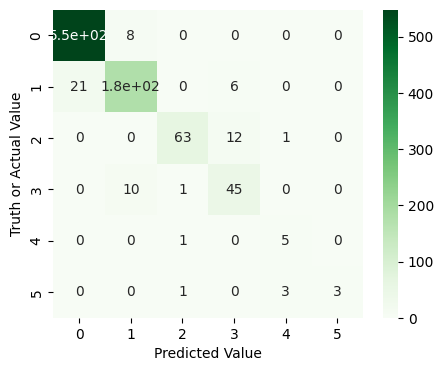

In [20]:
plt.figure(figsize = (5,4))
sns.heatmap(test, annot = True, cmap = 'Greens')
plt.xlabel('Predicted Value')
plt.ylabel('Truth or Actual Value')
plt.show()

#### 2. Các thông số đánh giá: Accuracy, Precision, Recall

 Độ so khớp của mô hình với dữ liệu (%)

In [21]:
print("Accuracy:", metrics.accuracy_score(y_test, predicted_output))

Accuracy: 0.9293598233995585


Với confusion matrix ở trên do ở đây ta thực hiên phân lớp tới 6 loại label khác nhau, nên việc tính toán các giá trị TP FP TN FN có vẻ khá tốn thời gian nên chúng ta sẽ sử dụng hàm classification_report để tính toán ra được giá trị precision, recall tương ứng với từng label.

In [22]:
#Precision Recall
print(metrics.classification_report(y_test, predicted_output)) 

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.97       556
         2.0       0.91      0.87      0.89       205
         3.0       0.95      0.83      0.89        76
         4.0       0.71      0.80      0.76        56
         5.0       0.56      0.83      0.67         6
         6.0       1.00      0.43      0.60         7

    accuracy                           0.93       906
   macro avg       0.85      0.79      0.80       906
weighted avg       0.93      0.93      0.93       906



**NHẬN XÉT:**

Với mô hình được sử dụng ở trên có vẻ accuracy mang lại có vẻ khá cao và chính xác, nhưng không thuộc vào trường hợp overfitting

# SO SÁNH 2 MÔ HÌNH


Cả 2 mô hình đều là phương pháp học có giám sát **(Supervised Learning)**.

- **Random Forests** là một phương pháp thống kê mô hình hóa bằng máy (machine learning statistic) dùng để phục vụ các mục đích phân loại, tính hồi quy và các nhiệm vụ khác bằng cách xây dựng nhiều cây quyết định (Decision tree).
- **Logistic Regression** là thuật toán đơn giản nhưng lại rất hiệu quả trong bài toán phân loại (Classification), là một phương pháp phân tích thống kê được sử dụng để dự đoán giá trị dữ liệu dựa trên các quan sát trước đó của tập dữ liệu.


Sử dụng **Confusion Matrix** để đánh giá sẽ giúp có cái nhìn rõ hơn về việc các điểm dữ liệu được phân loại đúng/sai như thế nào. Cả 2 mô hình đều sử dụng Confusion matrix nhằm giúp ta so sánh dễ hơn tính hiệu quả của 2 mô hình với bài toán.

In [23]:
#Precision Recall
#Random Forest
print("Random Forest: ")
print(metrics.classification_report(y_test, y_pred)) 

#Logistic Regression
print("Logistic Regression: ")
print(metrics.classification_report(y_test, predicted_output)) 

Random Forest: 
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       556
         2.0       0.99      1.00      1.00       205
         3.0       0.95      1.00      0.97        76
         4.0       1.00      0.96      0.98        56
         5.0       0.50      0.50      0.50         6
         6.0       1.00      0.43      0.60         7

    accuracy                           0.99       906
   macro avg       0.91      0.82      0.84       906
weighted avg       0.99      0.99      0.99       906

Logistic Regression: 
              precision    recall  f1-score   support

         1.0       0.96      0.99      0.97       556
         2.0       0.91      0.87      0.89       205
         3.0       0.95      0.83      0.89        76
         4.0       0.71      0.80      0.76        56
         5.0       0.56      0.83      0.67         6
         6.0       1.00      0.43      0.60         7

    accuracy                           

Sau khi đánh giá mô hình trên tập dự liệu test thì độ chính xác (Accuracy) của mô hình Logistic Regression thấp hơn Random Forest khoảng 8%. Về hệ số dự đoán (Precision), mô hình Random forest đều dự đoán chính xác hơn Logistic Regression ở từng label. Tương tự, Random Forest cũng có độ bao phủ (Recall), giá trị trung bình điều hòa giữa Recall và Precision (Fl-score) đều cao hơn mô hình Logistic Regression.

**Tại sao trong bài toán này mô hình Random Forest lại hiệu quả hơn mô hình Logistic Regression ?**

 - Random Forest cho thấy hiệu quả hơn so với thuật toán phân loại thường được sử dụng vì có khả năng tìm ra thuộc tính nào quan trọng hơn so với những thuộc tính khác.Trên thực tế, nó còn có thể chỉ ra rằng một số thuộc tính là không có tác dụng trong cây quyết định. Còn về Logistic Regression có các thuộc tính không có mối quan hệ lẫn nhau.
 - Nói như thế không phải mô hình Logistic Regression không hiệu quả mà nó còn phụ thuộc vào dữ liệu, bài toán mà ta cần thực hiện cũng như phương pháp đánh giá mô hình ta chọn.
 
 **=> Ở bài toán này, dùng mô hình Random Forest sẽ hiệu quả hơn Logistic Regression.**

Tuy nhiên, với độ accuracy là rất cao ~0.99 thì ta có thể đoán ra được mô hình Random Forest đang bị **Over Fitting**. Do đó ta cần nhiều tập test và train để kiểm tra thêm mô hình có thật sự chính xác hay không.